# Data Pre-processing

In [1]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!wget https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz

!tar -xvzf cifar-10-python.tar.gz
!tar -xvzf cifar-100-python.tar.gz


--2025-12-04 08:43:37--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  16.7MB/s    in 15s     

2025-12-04 08:43:53 (10.6 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

--2025-12-04 08:43:53--  https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169001437 (161M) [application/x-gzip]
Saving to: ‘cifar-100-python.tar.gz’

cifar-100-python.ta 100%[===================>] 161.17M  49.0MB/s    in 3.8s    

2025-12-04 08:43:57 (4

### Extracting the data

In [2]:
!tar -xvzf cifar-10-python.tar.gz
!tar -xvzf cifar-100-python.tar.gz

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1
cifar-100-python/
cifar-100-python/file.txt~
cifar-100-python/train
cifar-100-python/test
cifar-100-python/meta


### Load CIFAR10

In [3]:
import pickle
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import random
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

def unpickle(file):
    with open(file, 'rb') as f:
        return pickle.load(f, encoding='bytes')

# CIFAR-10
meta10 = unpickle("cifar-10-batches-py/batches.meta")
cifar10_classes = [x.decode('utf-8') for x in meta10[b'label_names']]

print("CIFAR-10 classes:")
for i, name in enumerate(cifar10_classes):
    print(i, name)

CIFAR-10 classes:
0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


### Extract the ids we need for CIFAR-10

In [4]:
cifar10_needed_ids = [1, 2, 3, 4, 5, 7, 9] # automobile, bird, cat, deer, dog, horse, truck

X_train_10 = []
y_train_10 = []

for i in range(1, 6):
    batch = unpickle(f"cifar-10-batches-py/data_batch_{i}")
    X_train_10.append(batch[b'data'])
    y_train_10.append(batch[b'labels'])

X_train_10 = np.concatenate(X_train_10)
y_train_10 = np.concatenate(y_train_10)

# filter only needed CIFAR-10 classes
train_mask_10 = np.isin(y_train_10, cifar10_needed_ids)
X_train_10_filtered = X_train_10[train_mask_10]
y_train_10_filtered = y_train_10[train_mask_10]

# filter CIFAR-10 test batch
test_batch = unpickle("cifar-10-batches-py/test_batch")
X_test_10 = test_batch[b'data']
y_test_10 = np.array(test_batch[b'labels'])

test_mask_10 = np.isin(y_test_10, cifar10_needed_ids)
X_test_10_filtered = X_test_10[test_mask_10]
y_test_10_filtered = y_test_10[test_mask_10]

print(X_train_10_filtered.shape, y_train_10_filtered.shape)
print(X_test_10_filtered.shape, y_test_10_filtered.shape)

(35000, 3072) (35000,)
(7000, 3072) (7000,)


### Load CIFAR100

In [5]:
# CIFAR-100
meta100 = unpickle("cifar-100-python/meta")
train_100 = unpickle("cifar-100-python/train")
test_100 = unpickle("cifar-100-python/test")

cifar100_fine_classes = [x.decode('utf-8') for x in meta100[b'fine_label_names']]
cifar100_coarse_classes = [x.decode('utf-8') for x in meta100[b'coarse_label_names']]

trees_coarse_idx = cifar100_coarse_classes.index('trees')

# Checking if our ids are correct

# print("CIFAR-100 fine labels:")
# for i, name in enumerate(cifar100_fine_classes):
#     print(i, name)

# print("\nCIFAR-100 coarse labels:")
# for i, name in enumerate(cifar100_coarse_classes):
#     print(i, name)

cifar100_target_fine = ['cattle', 'fox', 'baby', 'boy', 'girl', 'man', 'woman', 'rabbit', 'squirrel', 'bicycle', 'bus', 'motorcycle', 'pickup_truck', 'train', 'lawn_mower', 'tractor']

# cifar100_needed_ids = [i for i, name in enumerate(cifar100_fine_classes) if name in target_fine_classes]
# print("Selected fine IDs:", cifar100_needed_ids)


### Extract the ids we need for CIFAR-100

In [6]:
X_train_100 = train_100[b'data']
y_train_100_fine = np.array(train_100[b'fine_labels'])
y_train_100_coarse = np.array(train_100[b'coarse_labels'])

X_test_100 = test_100[b'data']
y_test_100_fine = np.array(test_100[b'fine_labels'])
y_test_100_coarse = np.array(test_100[b'coarse_labels'])

def select_and_map_cifar100(X, fine_labels, coarse_labels):
    kept_indices = []
    mapped_names = []
    for i, (f, c) in enumerate(zip(fine_labels, coarse_labels)):
        if c == trees_coarse_idx:
            kept_indices.append(i)
            mapped_names.append('trees')
        else:
            fine_name = cifar100_fine_classes[f]
            if fine_name in cifar100_target_fine:
                kept_indices.append(i)
                mapped_names.append(fine_name)
    X_filtered = X[kept_indices]
    return X_filtered, np.array(mapped_names)

X_train_100_filtered, y_train_100_names = select_and_map_cifar100(
    X_train_100, y_train_100_fine, y_train_100_coarse
)
X_test_100_filtered, y_test_100_names  = select_and_map_cifar100(
    X_test_100, y_test_100_fine, y_test_100_coarse
)

print("CIFAR-100 selected train shape:", X_train_100_filtered.shape, "labels:", y_train_100_names.shape)
print("CIFAR-100 selected test shape:", X_test_100_filtered.shape,  "labels:", y_test_100_names.shape)

CIFAR-100 selected train shape: (10500, 3072) labels: (10500,)
CIFAR-100 selected test shape: (2100, 3072) labels: (2100,)


### Remapping Label as ID to avoid collision

In [7]:
cifar10_selected_names = [cifar10_classes[i] for i in cifar10_needed_ids]

y_train_10_names = [cifar10_classes[i] for i in y_train_10_filtered]
y_test_10_names  = [cifar10_classes[i] for i in y_test_10_filtered]

cifar100_selected_names_ordered = list(dict.fromkeys(list(y_train_100_names) + list(y_test_100_names)))

cifar100_selected_names_explicit = ['cattle', 'fox', 'baby', 'boy', 'girl', 'man', 'woman', 'rabbit', 'squirrel', 'bicycle', 'bus', 'motorcycle', 'pickup_truck', 'train', 'lawn_mower', 'tractor', 'trees']

all_class_names = list(dict.fromkeys(cifar10_selected_names + cifar100_selected_names_explicit))

label_map = {name: idx for idx, name in enumerate(all_class_names)}

print("Unified class count:", len(label_map))
print("Label map:", label_map)

y_train_10_new = np.array([label_map[name] for name in y_train_10_names])
y_test_10_new  = np.array([label_map[name] for name in y_test_10_names])

y_train_100_new = np.array([label_map[name] for name in y_train_100_names])
y_test_100_new  = np.array([label_map[name] for name in y_test_100_names])

y_train_10_filtered  = y_train_10_new
y_test_10_filtered   = y_test_10_new
y_train_100_filtered = y_train_100_new
y_test_100_filtered  = y_test_100_new

X_train_combined = np.concatenate([X_train_10_filtered, X_train_100_filtered], axis=0)
y_train_combined = np.concatenate([y_train_10_filtered, y_train_100_filtered], axis=0)
X_test_combined  = np.concatenate([X_test_10_filtered,  X_test_100_filtered],  axis=0)
y_test_combined  = np.concatenate([y_test_10_filtered,  y_test_100_filtered],  axis=0)

print("Combined train shape:", X_train_combined.shape, y_train_combined.shape)
print("Combined test shape:",  X_test_combined.shape,  y_test_combined.shape)

print("Unique training labels:", np.unique(y_train_combined))
print("Unique test labels: ", np.unique(y_test_combined))

Unified class count: 24
Label map: {'automobile': 0, 'bird': 1, 'cat': 2, 'deer': 3, 'dog': 4, 'horse': 5, 'truck': 6, 'cattle': 7, 'fox': 8, 'baby': 9, 'boy': 10, 'girl': 11, 'man': 12, 'woman': 13, 'rabbit': 14, 'squirrel': 15, 'bicycle': 16, 'bus': 17, 'motorcycle': 18, 'pickup_truck': 19, 'train': 20, 'lawn_mower': 21, 'tractor': 22, 'trees': 23}
Combined train shape: (45500, 3072) (45500,)
Combined test shape: (9100, 3072) (9100,)
Unique training labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Unique test labels:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


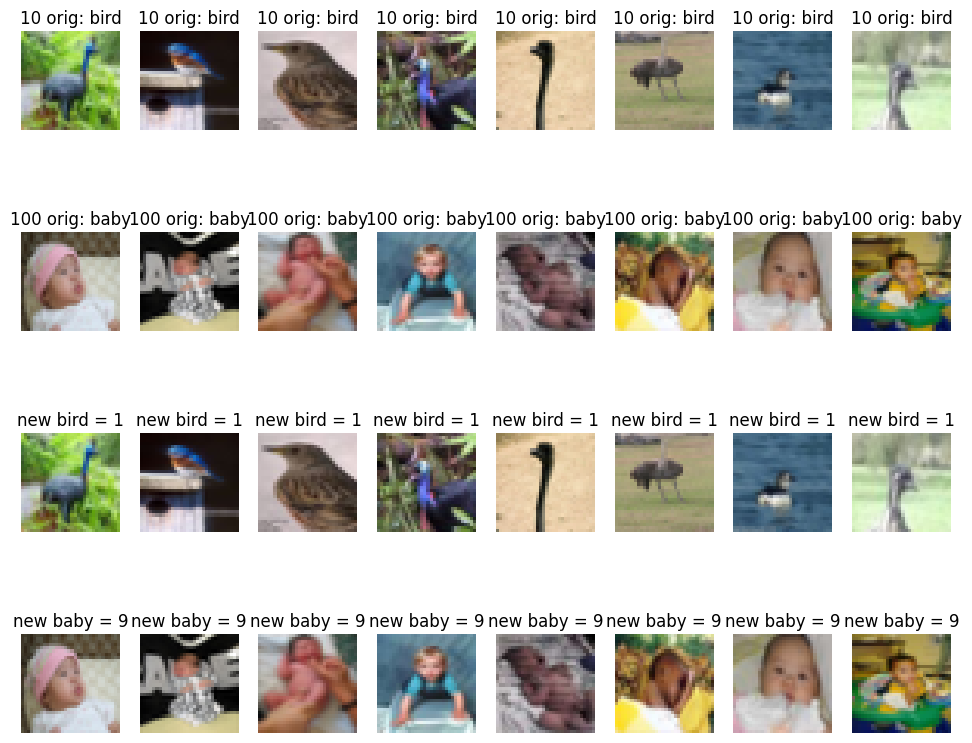

In [8]:
orig_class_10 = "bird"
orig_class_100 = "baby"

orig_label_10 = cifar10_classes.index(orig_class_10)
orig_label_100 = cifar100_fine_classes.index(orig_class_100)

# original samples
indices_10_orig = np.where(y_train_10 == orig_label_10)[0][:8]
indices_100_orig = np.where(y_train_100_fine == orig_label_100)[0][:8]

# new mapped labels
new_label_10 = label_map[orig_class_10]
new_label_100 = label_map[orig_class_100]

indices_10_new = np.where(y_train_10_filtered == new_label_10)[0][:8]
indices_100_new = np.where(y_train_100_filtered == new_label_100)[0][:8]

plt.figure(figsize=(12, 10))

# CIFAR-10 original
for i, idx in enumerate(indices_10_orig):
    img = X_train_10[idx].reshape(3, 32, 32).transpose(1, 2, 0)
    plt.subplot(4, 8, i+1)
    plt.imshow(img)
    plt.title("10 orig: bird")
    plt.axis("off")

# CIFAR-100 original
for i, idx in enumerate(indices_100_orig):
    img = X_train_100[idx].reshape(3, 32, 32).transpose(1, 2, 0)
    plt.subplot(4, 8, i+1+8)
    plt.imshow(img)
    plt.title("100 orig: baby")
    plt.axis("off")

# CIFAR-10 new label
for i, idx in enumerate(indices_10_new):
    img = X_train_10_filtered[idx].reshape(3, 32, 32).transpose(1, 2, 0)
    plt.subplot(4, 8, i+1+16)
    plt.imshow(img)
    plt.title(f"new bird = {new_label_10}")
    plt.axis("off")

# CIFAR-100 new label
for i, idx in enumerate(indices_100_new):
    img = X_train_100_filtered[idx].reshape(3, 32, 32).transpose(1, 2, 0)
    plt.subplot(4, 8, i+1+24)
    plt.imshow(img)
    plt.title(f"new baby = {new_label_100}")
    plt.axis("off")


### Combine CIFAR-10 and CIFAR-100 and save files

In [9]:
X_train_combined = np.concatenate([X_train_10_filtered, X_train_100_filtered])
y_train_combined = np.concatenate([y_train_10_filtered, y_train_100_filtered])

X_test_combined = np.concatenate([X_test_10_filtered, X_test_100_filtered])
y_test_combined = np.concatenate([y_test_10_filtered, y_test_100_filtered])

print("Combined shapes:", X_train_combined.shape, X_test_combined.shape)

X_train_combined = X_train_combined.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
X_test_combined  = X_test_combined.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

Combined shapes: (45500, 3072) (9100, 3072)


# Data Pre-processing

In [10]:
def equalize(img):
    return cv2.equalizeHist(img)

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def resize_28(img):
    return cv2.resize(img, (28, 28), interpolation=cv2.INTER_AREA)

def gaussian_blur(img, kernel_size=(3,3)):
    return cv2.GaussianBlur(img, kernel_size, 0)

# def normalize(img):
#     return img / 255.0
# this step is done in the model layer itself

def preprocessing(img):
    img = grayscale(img)
    img = resize_28(img)
    img = equalize(img)
    img = gaussian_blur(img)
    return img


In [11]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_combined,
    y_train_combined,
    test_size=0.1,
    shuffle=True,
    stratify=y_train_combined
)

In [12]:
X_train = np.array([preprocessing(img) for img in X_train])
X_val   = np.array([preprocessing(img) for img in X_val])
X_test  = np.array([preprocessing(img) for img in X_test_combined])

X_train = X_train[..., np.newaxis]
X_val   = X_val[..., np.newaxis]
X_test  = X_test[..., np.newaxis]

# Data Exploration

In [13]:
print("Final shapes:")
print("Train:", X_train.shape)
print("Val:",   X_val.shape)
print("Test:",  X_test.shape)

y_test = y_test_combined

Final shapes:
Train: (40950, 28, 28, 1)
Val: (4550, 28, 28, 1)
Test: (9100, 28, 28, 1)


In [14]:
print("Unique CIFAR-10 labels:", np.unique(y_train_10_filtered))
print("Unique CIFAR-100 labels:", np.unique(y_train_100_filtered))
print("Combined:", np.unique(y_train_combined))


Unique CIFAR-10 labels: [0 1 2 3 4 5 6]
Unique CIFAR-100 labels: [ 7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Combined: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


Number of classes: 24


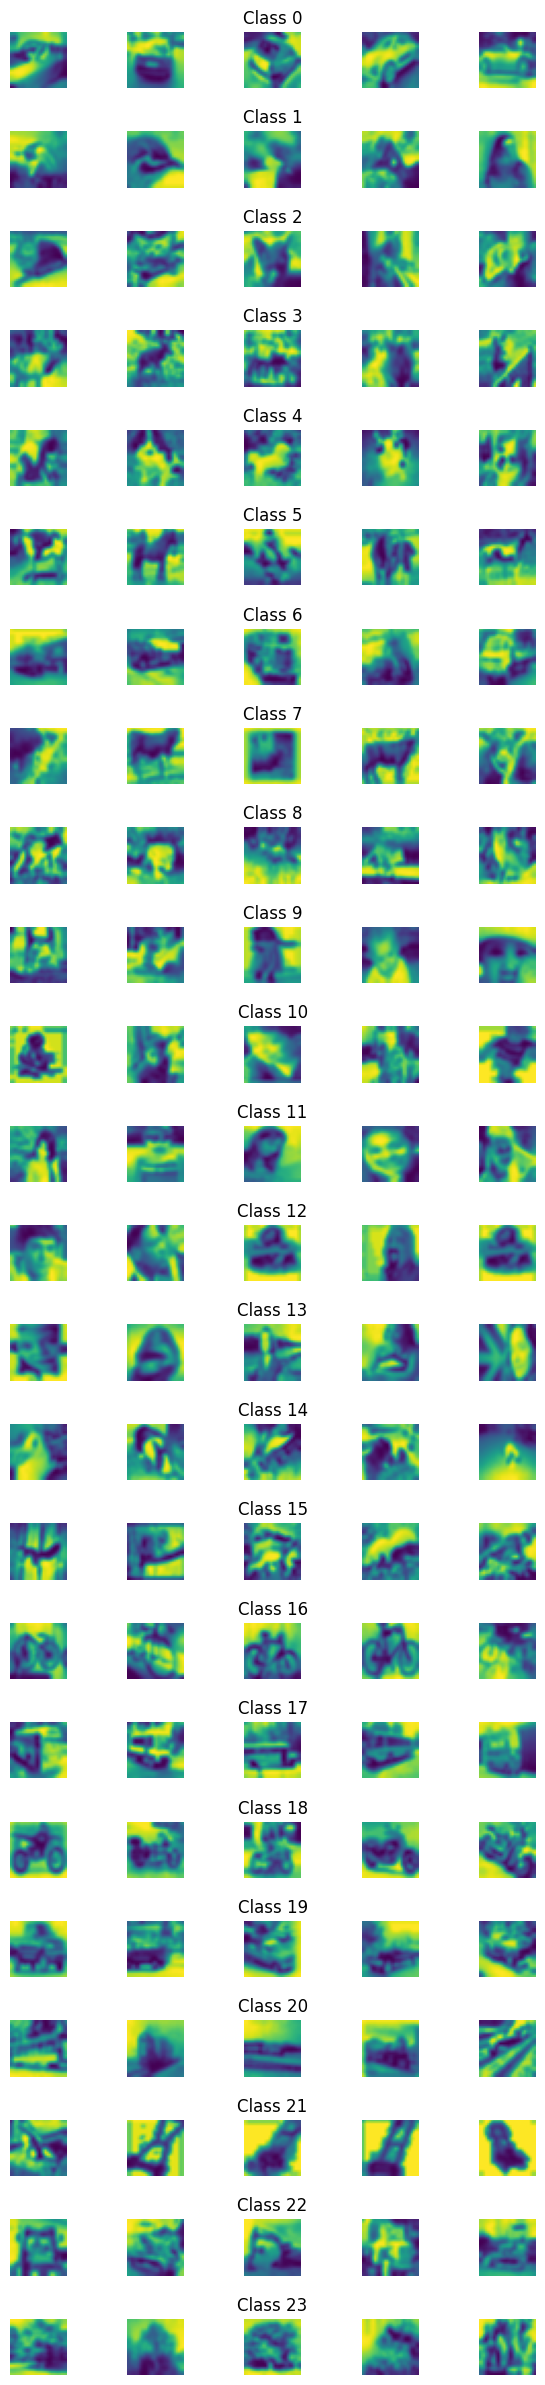

In [15]:
num_of_samples = []
cols = 5
classes = np.unique(y_train)
num_classes = len(classes)
print("Number of classes:", num_classes)

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(6, num_classes))
fig.tight_layout(pad=1)

for class_id_idx, class_id in enumerate(classes):
    x_selected = X_train[y_train == class_id]

    num_of_samples.append(len(x_selected))

    for col in range(cols):
        img = x_selected[random.randint(0, len(x_selected)-1)]

        axs[class_id_idx][col].imshow(img)
        axs[class_id_idx][col].axis("off")

        if col == cols // 2:
            axs[class_id_idx][col].set_title(f"Class {class_id}")

plt.show()


[4500, 4500, 4500, 4500, 4500, 4500, 4500, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 2250]


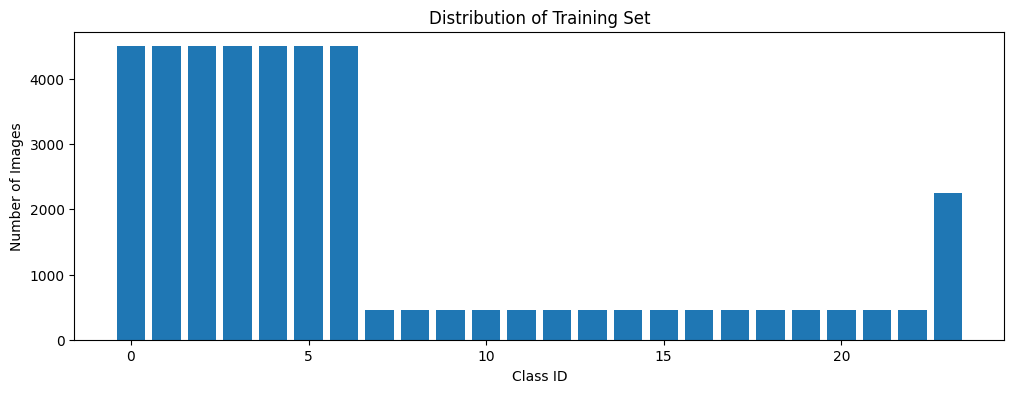

In [16]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(classes, num_of_samples)
plt.title("Distribution of Training Set")
plt.xlabel("Class ID")
plt.ylabel("Number of Images")
plt.show()

### Class Weights

In [ ]:
# num_classes = len(np.unique(y_train))
# print(f"Number of classes: {num_classes}")

# class_weights = compute_class_weight(
#     'balanced',
#     classes=np.unique(y_train),
#     y=y_train
# )

# class_weights = np.clip(class_weights, 0.5, 2.0)
# class_weights_dict = dict(enumerate(class_weights))

# unique, counts = np.unique(y_train, return_counts=True)
# print("\nClass distribution in training set:")
# for cls, cnt in zip(unique, counts):
#     print(f"  Class {cls}: {cnt} samples (weight: {class_weights_dict[cls]:.3f})")

Number of classes: 24

Class distribution in training set:
  Class 0: 4500 samples (weight: 0.500)
  Class 1: 4500 samples (weight: 0.500)
  Class 2: 4500 samples (weight: 0.500)
  Class 3: 4500 samples (weight: 0.500)
  Class 4: 4500 samples (weight: 0.500)
  Class 5: 4500 samples (weight: 0.500)
  Class 6: 4500 samples (weight: 0.500)
  Class 7: 450 samples (weight: 2.000)
  Class 8: 450 samples (weight: 2.000)
  Class 9: 450 samples (weight: 2.000)
  Class 10: 450 samples (weight: 2.000)
  Class 11: 450 samples (weight: 2.000)
  Class 12: 450 samples (weight: 2.000)
  Class 13: 450 samples (weight: 2.000)
  Class 14: 450 samples (weight: 2.000)
  Class 15: 450 samples (weight: 2.000)
  Class 16: 450 samples (weight: 2.000)
  Class 17: 450 samples (weight: 2.000)
  Class 18: 450 samples (weight: 2.000)
  Class 19: 450 samples (weight: 2.000)
  Class 20: 450 samples (weight: 2.000)
  Class 21: 450 samples (weight: 2.000)
  Class 22: 450 samples (weight: 2.000)
  Class 23: 2250 samples

### Saving the data to build the model in the model files

In [ ]:
save_data = {
    "X_train": X_train,
    "X_val": X_val,
    "X_test": X_test,
    "y_train": y_train,
    "y_val": y_val,
    "y_test": y_test,
    # "class_weights": class_weights_dict,
    "num_classes": num_classes
}

with open("prepared_data.pkl", "wb") as f:
    pickle.dump(save_data, f)

print("Data saved successfully!")

Data saved successfully!
